In [1]:
import tensorflow as tf
from time import time
import numpy
import os
import json
import pandas
import datetime

import sys
sys.path.append('../libs')

import data_pipeline
import conv_model
import initialize
import prepare_data

tf.debugging.set_log_device_placement(True)

In [2]:
! du -h -d 0 /scr-ssd/tflogs
! df -h | grep scr-ssd

311M	/scr-ssd/tflogs
/dev/nvme0n1                   1.1T 1002G   43G  96% /scr-ssd


In [3]:
! nvidia-smi

Fri Oct 18 15:10:26 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  On   | 00000000:05:00.0 Off |                  N/A |
| 22%   28C    P8    16W / 250W |      0MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  On   | 00000000:08:00.0 Off |                  N/A |
| 22%   36C    P8    30W / 250W |      0MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### Partition Data

In [7]:
metadata = pandas.read_csv('/scr-ssd/mimic/metadata_matched.csv')
subject_ids = metadata['subject_id'].unique()
numpy.random.shuffle(subject_ids)
i = round(0.2*len(subject_ids))
with open('../test_subject_ids.txt', 'w') as f:
    f.write('\n'.join(subject_ids[:i].astype('str')))

### Initialize

In [3]:
%%time

H = json.load(open('../hypes.json'))
metadata = initialize.load_metadata(H)
sig_data = initialize.load_sig_data(H, metadata)
partition = initialize.load_partition(H, metadata)

CPU times: user 51.7 s, sys: 11.1 s, total: 1min 2s
Wall time: 1min 2s


In [4]:
(sig_data['sig_index'] > 0).sum(axis=0)

sig_name
ABP      187783
AVR       71440
I          7608
II       171692
III       20082
MCL        8654
PLETH    131112
RESP      95549
V         97676
dtype: int64

### Plot Batch

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BroadcastTo in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replic

<IPython.core.display.Javascript object>


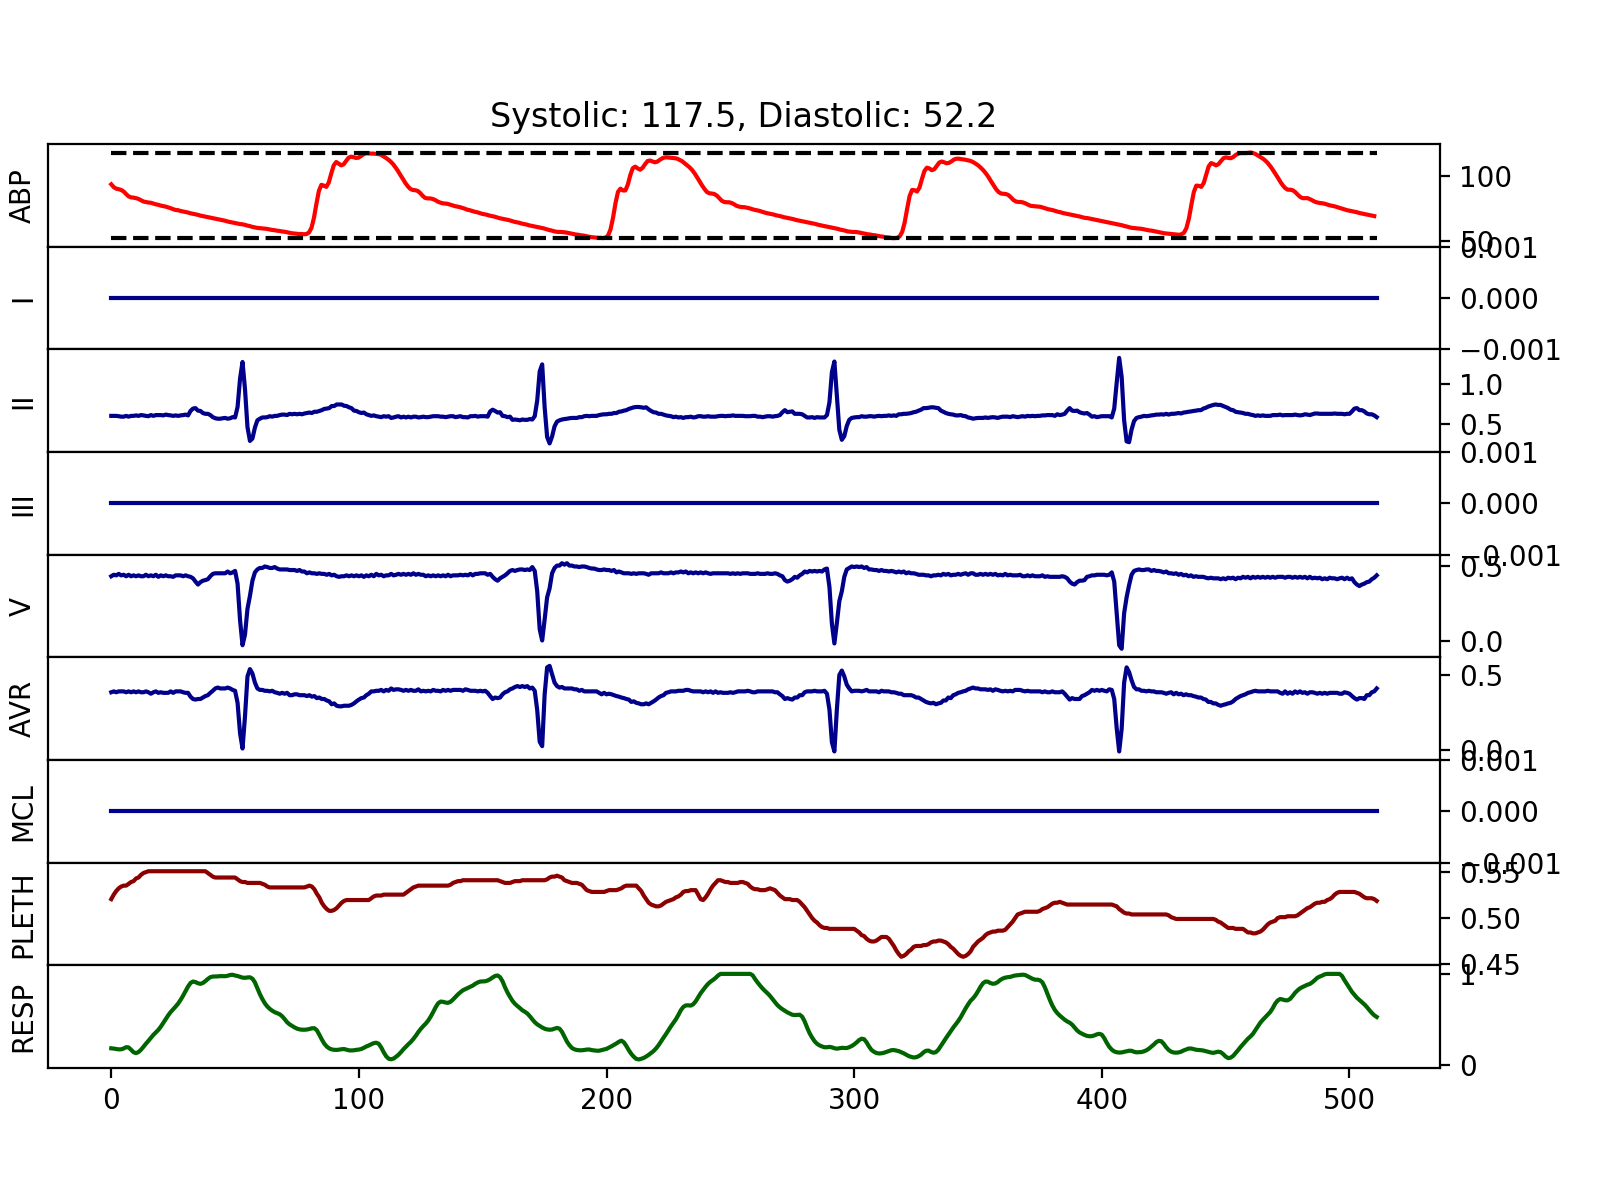

interactive(children=(IntSlider(value=0, description='i', max=31), Output()), _dom_classes=('widget-interact',…

In [5]:
%matplotlib notebook
from matplotlib import pyplot
from functools import partial
from ipywidgets import interact, IntSlider


S = H['output_sigs'] + H['input_sigs_train']
        
def plot_batch_example(H, x, y, i):
    pyplot.subplots_adjust(left=0.03, wspace=0, hspace=0)
    lines = {'sigs': {}, 'label': {}}
    axes = {}
    for j, s in enumerate(S):
        axes[s] = pyplot.subplot(len(S), 1, j + 1)
        line = axes[s].plot(x[i][:, j])[0]
        lines['sigs'][s] = line
        axes[s].set_ylabel(s)
        axes[s].yaxis.tick_right()
        if s in ['ABP', 'ART', 'CVP', 'PAP', 'ICP']:
            line.set_color('red')
        elif s in ['I', 'II', 'III', 'V', 'AVR', 'AVF', 'AVL', 'MCL', 'MCL1']:
            line.set_color('darkblue')
        elif s in ['RESP']:
            line.set_color('darkgreen')
        elif s in ['PLETH']:
            line.set_color('darkred')
    
    plot_y = lambda j: axes['ABP'].plot([0, H['window_size']], [y[i][j]] * 2, '--k')[0]
    lines['label'] = {'sys': plot_y(0), 'dia': plot_y(1)}
    
    return lines, axes

def update(i):
    for j, s in enumerate(S):
        lines['sigs'][s].set_ydata(x[i][:, j])
        low, high = x[i][:, j].min(), x[i][:, j].max()
        dx = max(0.01, high - low)
        axes[s].set_ylim(bottom = low - 0.1 * dx, top = high + 0.1 * dx)
    lines['label']['sys'].set_ydata([y[i][0]] * 2)
    lines['label']['dia'].set_ydata([y[i][1]] * 2)
    fig.axes[0].set_title('Systolic: %.1f, Diastolic: %.1f' % tuple(y[i]))
    fig.canvas.draw()
    pyplot.show()

H_ = {
    **H, 
    'input_sigs_train': ['ABP'] + H['input_sigs_train'], 
    'input_sigs_validation': ['ABP'] + H['input_sigs_validation'], 
    'epochs': 1, 
    'steps_per_epoch': 1,
    'batch_buffer_size': 1,
    'windows_per_chunk': 5,
}

dataframe = initialize.sample_data(H_, sig_data, is_validation=True)
tensors = initialize.dataframe_to_tensors(H_, dataframe)
dataset = data_pipeline.build(H_, tensors, is_validation=True)
x_tf, y_tf = next(iter(dataset))
x, y = x_tf.numpy(), y_tf.numpy()

fig = pyplot.figure(figsize=[8, 6])
lines, axes = plot_batch_example(H_, x, y, 0)

interact(update, i=IntSlider(min=0, max=H_['batch_size']-1, value=0));

### Filter Percentage

In [4]:
%%time

N = 10**4

H_ = {
    **H, 
    'epochs': 1,
    'steps_per_epoch': N / H['batch_size'] / 10 * 2,
    'batch_buffer_size': 1,
    'windows_per_chunk': 10,
    'filter_data': True
}

dataframe = initialize.sample_data(H_, sig_data)
print(dataframe.shape)
I = numpy.random.permutation(dataframe.shape[0] // H_['windows_per_chunk'])[:N // H_['windows_per_chunk']]
I = [i*H_['windows_per_chunk'] + j for i in I for j in range(H_['windows_per_chunk'])]
tensors = initialize.dataframe_to_tensors(H_, dataframe.iloc[I])
dataset = data_pipeline.build(H_, tensors)
n = sum(i[0].shape[0] for i in dataset)
round(n / N * 100, 1)

(194980, 24)
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:l

85.3

In [5]:
%%time

N = 10**4

H_ = {
    **H, 
    'epochs': 1,
    'steps_per_epoch': N / H['batch_size'] / 10 * 2,
    'batch_buffer_size': 1,
    'windows_per_chunk': 10,
    'filter_data': True
}

dataframe = initialize.sample_data(H_, sig_data)
print(dataframe.shape)
I = numpy.random.permutation(dataframe.shape[0] // H_['windows_per_chunk'])[:N // H_['windows_per_chunk']]
I = [i*H_['windows_per_chunk'] + j for i in I for j in range(H_['windows_per_chunk'])]
tensors = initialize.dataframe_to_tensors(H_, dataframe.iloc[I])
dataset = data_pipeline.build(H_, tensors)
n = sum(i[0].shape[0] for i in dataset)
round(n / N * 100, 1)

(194980, 24)
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
CPU times: user 47.8 s, sys: 1.03 s, total: 48.9 s
Wall time: 36.8 s


15.8

### Fit Model

In [7]:
%%time

dataset = {
    'train': pipeline.build(H, dataframes['train']),
    'validation': pipeline.build(H, dataframes['validation']),
}

model = conv_model.build(H)

model.summary()

logdir = os.path.join('/scr-ssd/tflogs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, embeddings_freq=5)

model.fit(
    dataset['train'],
    validation_data = dataset['validation'],
    epochs = H['epochs'],
    steps_per_epoch = H['steps_per_epoch'],
    validation_steps = H['steps_per_epoch'],
    callbacks = [tensorboard_callback]
)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BroadcastTo in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in devi

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 5)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 512, 1)]     0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 512, 1)]     0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 512, 1)]     0           input_1[0][0]                    
______________________________________________________________________________________________

Total params: 4,281,474
Trainable params: 4,281,474
Non-trainable params: 0
__________________________________________________________________________________________________
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 500 steps, validate for 500 steps
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteGraphSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/100
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelD

W1014 06:45:14.343450 140340961675008 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.441447). Check your callbacks.


  2/500 [..............................] - ETA: 1:32:06 - loss: 17.0316

W1014 06:45:14.389593 140340961675008 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.222232). Check your callbacks.
W1014 06:45:14.441110 140340961675008 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (0.111152). Check your callbacks.


499/500 [============================>.] - ETA: 0s - loss: 15.7254Executing op __inference_distributed_function_4710 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SaveV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SaveV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MergeV2Checkpoints in device /job:localhost/replica:0/task:0/device:CPU:0
500/500 [==============================] - 193s 387ms/step - loss: 15.7283 - val_loss: 16.2870


W1014 07:59:36.409335 140340961675008 training_v2.py:146] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50000 batches). You may need to use the repeat() function when building your dataset.


 61/500 [==>...........................] - ETA: 18s - loss: 12.1448Executing op CloseSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0
CPU times: user 5h 54min 41s, sys: 25min 34s, total: 6h 20min 16s
Wall time: 1h 14min 54s


### Build Model

#### Fully Connected

In [ ]:
def simple_fc_model(H):
    inputs = tf.keras.layers.Input(shape=(H['window_size'], len(H['input_sigs'])))
    z = tf.keras.layers.Flatten()(inputs)
    for i in range(3):
        z = tf.keras.layers.Dense(H['dense_units'], activation=H['activation'])(z)
    final_layer = tf.keras.layers.Dense(2)
    outputs = final_layer(z)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    final_layer.set_weights([
        final_layer.get_weights()[0],
        tf.keras.backend.constant([120, 60], dtype='float32')
    ])

    optimizer = getattr(tf.keras.optimizers, H['optimizer']['name'].title())

    model.compile(
        optimizer = optimizer(**H['optimizer']['args']),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

#### Simple Convolution

In [8]:
def simple_conv_model(H):
    inputs = z = tf.keras.layers.Input(shape=(H['window_size'], len(H['input_sigs'])))

    for i in range(3):
        layer = tf.keras.layers.Conv1D(
            filters=128, 
            padding='same', 
            strides=4,
            kernel_size=32,
            activation='relu'
        )
        z = layer(z)

    z = tf.keras.layers.Flatten()(z)
    z = tf.keras.layers.Dense(128, activation='relu')(z)
    final_layer = tf.keras.layers.Dense(2)
    outputs = final_layer(z)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    final_layer.set_weights([
        final_layer.get_weights()[0],
        tf.keras.backend.constant([120, 60], dtype='float32')
    ])

    optimizer = getattr(tf.keras.optimizers, H['optimizer']['name'].title())

    model.compile(
        optimizer = optimizer(**H['optimizer']['args']),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

#### Initial Bias

In [ ]:
model = conv_model.build(H)
data = sample_data(H)
x, y = next(iter(data['train']))
model.predict_on_batch(x).numpy().mean(0)

#### Overfit Batch

In [ ]:
data = sample_data(H)
x, y = next(iter(data['train']))
data['train'] = tf.data.Dataset.from_tensors((x, y)).repeat(5000)
model.fit(data['train'])

#### Zero Input

In [ ]:
%%time

model = simple_conv_model(H)
for i in range(3):
    data = sample_data(H)
    for k in ['train', 'validation']:
        data[k] = data[k].map(lambda x, y: (x*0, y))
    model.fit(data['train'])
    model.evaluate(data['validation'])

#### Simple Conv

In [ ]:
%%time

model = simple_conv_model(H)
for i in range(3):
    data = sample_data(H)
    model.fit(data['train'])
    model.evaluate(data['validation'])

#### Custom Conv

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs --host '0.0.0.0'

### Constant Prediction

In [ ]:
x = tf.keras.layers.Input(shape=(H['window_size'], len(H['input_sigs'])))
z = x[:2, 0, 0]
z *= tf.constant([0, 0], dtype='float32')
z += tf.constant([121.8906, 60.182236], dtype='float32')

const_model = tf.keras.models.Model(inputs=x, outputs=z)
const_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'])
data = sample_data(H)
const_model.evaluate(data['validation'])

In [ ]:
data_util.calculate_training_speed(H, 5000, seconds_to_train=110)

In [14]:
df = pandas.DataFrame([
    {'CPU count': 16, 'GPU count': 3, 'Format': 'flac',   'Windows': 10,   'Speed (days/hr)': 14},
    {'CPU count': 16, 'GPU count': 6, 'Format': 'flac',   'Windows': 10,   'Speed (days/hr)': 22},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'flac',   'Windows': 50,   'Speed (days/hr)': 65},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'flac',   'Windows': 1000, 'Speed (days/hr)': 107},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'flac',   'Windows': 1000, 'Speed (days/hr)': 182},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'zlib',   'Windows': 10,   'Speed (days/hr)': 24},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'zlib',   'Windows': 50,   'Speed (days/hr)': 93},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'zlib',   'Windows': 100,  'Speed (days/hr)': 112},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'serial', 'Windows': 10,   'Speed (days/hr)': 68},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'serial', 'Windows': 50,   'Speed (days/hr)': 178},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'serial', 'Windows': 100,  'Speed (days/hr)': 210},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'serial', 'Windows': 1000, 'Speed (days/hr)': 311},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'chunks', 'Windows': 10,   'Speed (days/hr)': 248},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'memory', 'Windows': -1,   'Speed (days/hr)': 345},
    {'CPU count': 16, 'GPU count': 6, 'Format': 'memory', 'Windows': -1,   'Speed (days/hr)': 459},
])
df.sort_values('Speed (days/hr)')

,CPU count,GPU count,Format,Windows,Speed (days/hr)
0,16,3,flac,10,14
1,16,6,flac,10,22
5,16,3,zlib,10,24
2,16,3,flac,50,65
8,16,3,serial,10,68
6,16,3,zlib,50,93
3,16,3,flac,1000,107
7,16,3,zlib,100,112
9,16,3,serial,50,178
4,16,3,flac,1000,182


### Dummy Data in Memory

In [ ]:
n_batches = 1000

x = tf.random.uniform(
    shape = [n_batches, H['batch_size'], H['window_size'], len(H['input_sigs'])],
    minval = -1,
    maxval = 1,
)
y = tf.random.uniform(shape=[n_batches, H['batch_size'], 2], minval=40, maxval=200)
dummy_data = tf.data.Dataset.from_tensor_slices((x, y))
model = conv_model.build(H)

%time model.fit(dummy_data, shuffle=False)